# Capstone Project Part 08: Model Benchmarks

## Import libraries and modules

In [237]:
# Basic libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline

# Modelling libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

# Popular boosting package, separate from `sklearn`. (Many Kaggle competitions have been won with `XGBoost`.)
from xgboost import XGBClassifier

# Modelling using neural networks
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

# Use graphviz to make a chart of the regression tree decision points:
from six import StringIO  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image

## Load preprocessed data

Load `preprocessed.csv` from `data` folder into a pandas DataFrame.

In [2]:
df = pd.read_csv('../data/preprocessed.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3452 entries, 0 to 3451
Columns: 171 entries, year to sector_Wireless Telecommunication Services
dtypes: float64(37), int64(133), object(1)
memory usage: 4.5+ MB


---

## Set up X and y

In [3]:
target = 'cap'
X = df[[f for f in df.columns if f not in target and f != 'security' and f != 'year']]
y = df[target]

---

## Train/Test Split

Our goal is to:
- avoid overfitting in our model, and
- to get an unbiased estimate of model performance on new, 'unseen' data.

We always want to have a holdout set to test our model. Use the `train_test_split` function to split our X and y variables into a training set and a holdout set.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

---

## `StandardScaler`

Use an instance of `StandardScaler` to scale `X_train` and `X_test` for any model that uses Gradient Descent.

In [5]:
# Normalize X
ss = StandardScaler()

---

## Instantiate Models

In [6]:
lr = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('clf', LogisticRegression(max_iter=10_000, multi_class='multinomial'))
    ]),
    param_distributions={
        'clf__penalty': ['l2', 'none'],
        'clf__C': np.logspace(-5, 2), 
        'clf__class_weight': [None, 'balanced'],
        'clf__solver': ['newton-cg', 'sag', 'lbfgs']
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [7]:
lr_l1 = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('clf', LogisticRegression(penalty='l1', solver='saga', max_iter=10_000, multi_class='multinomial'))
    ]),
    param_distributions={
        'clf__C': np.logspace(-5, 2), 
        'clf__class_weight': [None, 'balanced']
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [8]:
enet = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('clf', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10_000, multi_class='multinomial'))
    ]),
    param_distributions={
        'clf__C': np.logspace(-5, 2), 
        'clf__class_weight': [None, 'balanced'],
        'clf__l1_ratio': np.linspace(0.1, 1)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [9]:
knn = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('clf', KNeighborsClassifier())
    ]),
    param_distributions={
        'clf__n_neighbors': np.arange(1, 22, 2), 
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['euclidean','manhattan']
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [10]:
bnb = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('clf', BernoulliNB())
    ]),
    param_distributions={
        'clf__alpha': np.logspace(-5, 2)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [11]:
gnb = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('clf', GaussianNB())
    ]),
    param_distributions={
        'clf__var_smoothing': np.logspace(-9, -4)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [12]:
tree = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('clf', DecisionTreeClassifier())
    ]),
    param_distributions={
        'clf__max_depth': list(np.arange(1, 5)) + [None],
        'clf__min_samples_split': np.arange(2, 21),
        'clf__min_samples_leaf': np.arange(1, 8),
        'clf__class_weight': [None, 'balanced']
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [13]:
bagged = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('clf', BaggingClassifier(DecisionTreeClassifier()))
    ]),
    param_distributions={
        'clf__base_estimator__max_depth': list(np.arange(1, 5)) + [None],
        'clf__base_estimator__min_samples_split': np.arange(2, 21),
        'clf__base_estimator__min_samples_leaf': np.arange(1, 8),
        'clf__base_estimator__class_weight': [None, 'balanced'],
        'clf__n_estimators': np.arange(1, 150)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [14]:
rf = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('clf', RandomForestClassifier())
    ]),
    param_distributions={
        'clf__max_depth': np.arange(1, 5),
        'clf__n_estimators': np.arange(1, 150),
        'clf__min_samples_split': np.arange(2, 21),
        'clf__min_samples_leaf': np.arange(1, 8),
        'clf__class_weight': [None, 'balanced', 'balanced_subsample']
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [15]:
et = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('clf', ExtraTreesClassifier())
    ]),
    param_distributions={
        'clf__max_depth': np.arange(1, 5),
        'clf__n_estimators': np.arange(1, 150),
        'clf__min_samples_split': np.arange(2, 21),
        'clf__min_samples_leaf': np.arange(1, 8),
        'clf__class_weight': [None, 'balanced', 'balanced_subsample']
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [16]:
ada = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('clf', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))
    ]),
    param_distributions={
        'clf__base_estimator__max_depth': list(np.arange(1, 5)) + [None],
        'clf__base_estimator__min_samples_split': np.arange(2, 21),
        'clf__base_estimator__min_samples_leaf': np.arange(1, 8),
        'clf__base_estimator__class_weight': [None, 'balanced'],
        'clf__n_estimators': np.arange(1, 150), 
        'clf__learning_rate': np.linspace(0.1, 1)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [17]:
gb = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('clf', GradientBoostingClassifier())
    ]),
    param_distributions={
        'clf__max_depth': np.arange(1, 5),
        'clf__n_estimators': np.arange(1, 150), 
        'clf__min_samples_split': np.arange(2, 21),
        'clf__min_samples_leaf': np.arange(1, 8),
        'clf__learning_rate': np.linspace(0.1, 1)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [18]:
vote = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('clf', VotingClassifier([
            ('tree', DecisionTreeClassifier()), 
            ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier())), 
            ('gb', GradientBoostingClassifier())
        ]))
    ]),
    param_distributions={
        'clf__tree__max_depth': list(np.arange(1, 5)) + [None],
        'clf__tree__min_samples_split': np.arange(2, 21),
        'clf__tree__min_samples_leaf': np.arange(1, 8),
        'clf__tree__class_weight': [None, 'balanced'],
        'clf__ada__base_estimator__max_depth': list(np.arange(1, 5)) + [None],
        'clf__ada__base_estimator__min_samples_split': np.arange(2, 21),
        'clf__ada__base_estimator__min_samples_leaf': np.arange(1, 8),
        'clf__ada__base_estimator__class_weight': [None, 'balanced'],
        'clf__ada__n_estimators': np.arange(1, 150), 
        'clf__ada__learning_rate': np.linspace(0.1, 1),
        'clf__gb__max_depth': np.arange(1, 5),
        'clf__gb__n_estimators': np.arange(1, 150), 
        'clf__gb__min_samples_split': np.arange(2, 21),
        'clf__gb__min_samples_leaf': np.arange(1, 8),
        'clf__gb__learning_rate': np.linspace(0.1, 1)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [19]:
xgb = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('clf', XGBClassifier(objective='multi:softprob'))
    ]),
    param_distributions={
        'clf__max_depth': np.arange(1, 25),
        'clf__n_estimators': np.arange(1, 1000), 
        'clf__learning_rate': np.linspace(0.1, 1)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [20]:
svm = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('clf', SVC(decision_function_shape='ovo'))
    ]),
    param_distributions={
        'clf__C': np.logspace(-5, 2),
        'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'clf__gamma': list(np.logspace(-5, 2)) + ['scale'],
        'clf__class_weight': [None, 'balanced']
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [21]:
# Since this is a multiclass classification problem, keras needs y to be a one-hot encoded matrix.
y_train_dummies = pd.get_dummies(y_train)

def ffnn_fn(
    layer_one_neurons=18,
    layer_two_neurons=18,
    layer_one_dropout=0.5,
    layer_two_dropout=0.5,
    opt_learning_rate=0.01
):
    # Create a neural network using the Dense and Dropout layers from keras. 
    model = Sequential()
    model.add(Dense(layer_one_neurons, activation='relu', kernel_regularizer=l2(), input_dim=X_train.shape[1]))
    model.add(Dropout(layer_one_dropout))
    model.add(Dense(layer_two_neurons, activation='relu', kernel_regularizer=l2()))
    model.add(Dropout(layer_two_dropout))
    
    # Activation function for the final output layer needs to be softmax 
    # to accomidate the three different classes.
    model.add(Dense(y_train_dummies.shape[1], activation='softmax'))
    
    ad = Adam(learning_rate=opt_learning_rate)
    
    # Compile model
    # Since this is a multiclass classification problem,loss function is categorical_crossentropy.
    model.compile(optimizer=ad, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

ffnn = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('clf', KerasClassifier(build_fn=ffnn_fn, verbose=0))
    ]),
    param_distributions={
        'clf__layer_one_neurons': np.arange(10, X_train.shape[1]),
        'clf__layer_two_neurons': np.arange(10, X_train.shape[1]),
        'clf__layer_one_dropout': np.linspace(0.5, 0.8),
        'clf__layer_two_dropout': np.linspace(0.5, 0.8),
        'clf__opt_learning_rate': np.logspace(-4, -1),
        'clf__batch_size': [128, 256],
        'clf__epochs': np.arange(5, 50)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

---

## Fit The Models On Training Data

In [22]:
lr.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.9min finished
/Users/junkai/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=1

In [23]:
lr_l1.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=1

In [24]:
enet.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=1

In [25]:
knn.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.8s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              KNeighborsClassifier(algorithm='auto',
                                                                   leaf_size=30,
                                                                   metric='minkowski',
                                                                   metric_params=None,
                                                                   n_jobs=None,
                                                                   n_neighbors=5,
                                                         

In [26]:
bnb.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              BernoulliNB(alpha=1.0,
                                                          binarize=0.0,
                                                          class_prior=None,
                                                          fit_prior=True))],
                                      verbose=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'clf__alpha': array([1.00000000e-05, 1.38949549e-05,...
       3.72759372e-01, 5.17947468e-01, 7.19685673e-01, 1.00000

In [27]:
gnb.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              GaussianNB(priors=None,
                                                         var_smoothing=1e-09))],
                                      verbose=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'clf__var_smoothing': array([1.00000000e-09, 1.26485522e-09, 1.59985872e-09, 2...
       1.84206997e-06, 2.32995181e-06, 2.94705170e-06, 3.72759372e-06,
       4.71486636e-06, 5.96362332e-06, 7.54312006e-06, 9.54095476e-06,
       1.20679264e-05, 1.52641797e-05

In [28]:
tree.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.1s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              DecisionTreeClassifier(class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features=None,
                                                                     max_leaf_nodes=None,
                                                                     min_impurity_decrease=0.0,
                         

In [29]:
bagged.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.1s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                                      criterion='gini',
                                                                                                      max_depth=None,
                                                                                                      max_features=None,
                                                                               

In [30]:
rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.3s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              RandomForestClassifier(bootstrap=True,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
                                  

In [31]:
et.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.5s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              ExtraTreesClassifier(bootstrap=False,
                                                                   class_weight=None,
                                                                   criterion='gini',
                                                                   max_depth=None,
                                                                   max_features='auto',
                                                                   max_leaf_nodes=None,
                                             

In [32]:
ada.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              AdaBoostClassifier(algorithm='SAMME.R',
                                                                 base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                                       criterion='gini',
                                                                                                       max_depth=None,
                                                                                                       max_feat

In [33]:
gb.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   59.8s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              GradientBoostingClassifier(criterion='friedman_mse',
                                                                         init=None,
                                                                         learning_rate=0.1,
                                                                         loss='deviance',
                                                                         max_depth=3,
                                                                         max_features=None,
                

In [34]:
vote.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              VotingClassifier(estimators=[('tree',
                                                                            DecisionTreeClassifier(class_weight=None,
                                                                                                   criterion='gini',
                                                                                                   max_depth=None,
                                                                                                   max_features=None,
       

In [35]:
xgb.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 12.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            colsample_bylevel=1,
                                                            colsample_bytree=1,
                                                            gamma=0,
                                                            learning_rate=0.1,
                                                            max_delta_step=0,
                  

In [36]:
svm.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.5s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              SVC(C=1.0, cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovo',
                                                  degree=3,
                                                  gamma='auto_deprecated',
                                                  kernel='rbf', max_iter=-1,
                                                  probability=False,
                                            

In [37]:
ffnn.fit(X_train, y_train_dummies)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/junkai/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('clf',
                                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x140b11e50>)],
                                      verbose=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'clf__batch_size': [128, 256],
                                        'clf__epochs': array([ 5,  6,...
       0.00339322, 0.00390694, 0.00449843, 0.00517947, 0.00596362,
       0.00686649, 0.00790604, 0.00910298, 0.01048113, 0.01206793,
       0.01389495, 0.01599859, 0.0184207 , 0.02120951, 0.

---

## Evaluate Models On Test Data

In [233]:
target_names = ['large-cap', 'mid-cap', 'small-cap']

In [38]:
print("Best Combination Of Hyperparameters:", lr.best_params_) 
print("Best Accuracy:", lr.best_score_)
print(
    classification_report(
        y_test,
        lr.predict(X_test), 
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__solver': 'newton-cg', 'clf__penalty': 'none', 'clf__class_weight': None, 'clf__C': 100.0}
Best Accuracy: 0.8999613750482812
              precision    recall  f1-score   support

   large-cap       1.00      1.00      1.00       474
     mid-cap       0.68      0.66      0.67       151
   small-cap       0.79      0.80      0.80       238

    accuracy                           0.89       863
   macro avg       0.82      0.82      0.82       863
weighted avg       0.89      0.89      0.89       863



In [39]:
print("Best Combination Of Hyperparameters:", lr_l1.best_params_) 
print("Best Accuracy:", lr_l1.best_score_)
print(
    classification_report(
        y_test,
        lr_l1.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__class_weight': 'balanced', 'clf__C': 19.306977288832496}
Best Accuracy: 0.8906913866357667
              precision    recall  f1-score   support

   large-cap       1.00      1.00      1.00       474
     mid-cap       0.62      0.78      0.69       151
   small-cap       0.83      0.70      0.76       238

    accuracy                           0.88       863
   macro avg       0.82      0.83      0.82       863
weighted avg       0.89      0.88      0.88       863



In [40]:
print("Best Combination Of Hyperparameters:", enet.best_params_) 
print("Best Accuracy:", enet.best_score_)
print(
    classification_report(
        y_test, 
        enet.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__l1_ratio': 0.8346938775510204, 'clf__class_weight': 'balanced', 'clf__C': 2.682695795279722}
Best Accuracy: 0.8887601390498262
              precision    recall  f1-score   support

   large-cap       1.00      1.00      1.00       474
     mid-cap       0.62      0.81      0.71       151
   small-cap       0.85      0.69      0.76       238

    accuracy                           0.88       863
   macro avg       0.83      0.83      0.82       863
weighted avg       0.89      0.88      0.88       863



In [41]:
print("Best Combination Of Hyperparameters:", knn.best_params_) 
print("Best Accuracy:", knn.best_score_)
print(
    classification_report(
        y_test,
        knn.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__weights': 'distance', 'clf__n_neighbors': 5, 'clf__metric': 'euclidean'}
Best Accuracy: 0.9096176129779838
              precision    recall  f1-score   support

   large-cap       1.00      1.00      1.00       474
     mid-cap       0.80      0.79      0.79       151
   small-cap       0.86      0.87      0.87       238

    accuracy                           0.93       863
   macro avg       0.89      0.89      0.89       863
weighted avg       0.93      0.93      0.93       863



In [42]:
print("Best Combination Of Hyperparameters:", bnb.best_params_) 
print("Best Accuracy:", bnb.best_score_)
print(
    classification_report(
        y_test,
        bnb.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__alpha': 0.00019306977288832496}
Best Accuracy: 0.8157589803012746
              precision    recall  f1-score   support

   large-cap       1.00      0.94      0.97       474
     mid-cap       0.43      0.68      0.53       151
   small-cap       0.72      0.55      0.62       238

    accuracy                           0.79       863
   macro avg       0.72      0.72      0.71       863
weighted avg       0.82      0.79      0.80       863



In [43]:
print("Best Combination Of Hyperparameters:", gnb.best_params_) 
print("Best Accuracy:", gnb.best_score_)
print(
    classification_report(
        y_test,
        gnb.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__var_smoothing': 3.0888435964774846e-05}
Best Accuracy: 0.8026264967168791
              precision    recall  f1-score   support

   large-cap       1.00      1.00      1.00       474
     mid-cap       0.45      0.94      0.61       151
   small-cap       0.88      0.28      0.42       238

    accuracy                           0.79       863
   macro avg       0.78      0.74      0.68       863
weighted avg       0.87      0.79      0.77       863



In [44]:
print("Best Combination Of Hyperparameters:", tree.best_params_) 
print("Best Accuracy:", tree.best_score_)
print(
    classification_report(
        y_test,
        tree.predict(X_test), 
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__min_samples_split': 6, 'clf__min_samples_leaf': 4, 'clf__max_depth': None, 'clf__class_weight': None}
Best Accuracy: 0.8709926612591734
              precision    recall  f1-score   support

   large-cap       0.95      0.97      0.96       474
     mid-cap       0.66      0.69      0.68       151
   small-cap       0.82      0.77      0.80       238

    accuracy                           0.87       863
   macro avg       0.81      0.81      0.81       863
weighted avg       0.87      0.87      0.87       863



In [45]:
print("Best Combination Of Hyperparameters:", bagged.best_params_) 
print("Best Accuracy:", bagged.best_score_)
print(
    classification_report(
        y_test,
        bagged.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__n_estimators': 48, 'clf__base_estimator__min_samples_split': 11, 'clf__base_estimator__min_samples_leaf': 3, 'clf__base_estimator__max_depth': None, 'clf__base_estimator__class_weight': None}
Best Accuracy: 0.9111626110467362
              precision    recall  f1-score   support

   large-cap       0.99      0.98      0.98       474
     mid-cap       0.77      0.79      0.78       151
   small-cap       0.88      0.87      0.87       238

    accuracy                           0.92       863
   macro avg       0.88      0.88      0.88       863
weighted avg       0.92      0.92      0.92       863



In [46]:
print("Best Combination Of Hyperparameters:", rf.best_params_) 
print("Best Accuracy:", rf.best_score_)
print(
    classification_report(
        y_test, 
        rf.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__n_estimators': 75, 'clf__min_samples_split': 20, 'clf__min_samples_leaf': 3, 'clf__max_depth': 4, 'clf__class_weight': None}
Best Accuracy: 0.805716492854384
              precision    recall  f1-score   support

   large-cap       0.89      0.97      0.93       474
     mid-cap       0.62      0.12      0.20       151
   small-cap       0.68      0.91      0.78       238

    accuracy                           0.80       863
   macro avg       0.73      0.67      0.63       863
weighted avg       0.79      0.80      0.76       863



In [47]:
print("Best Combination Of Hyperparameters:", et.best_params_) 
print("Best Accuracy:", et.best_score_)
print(
    classification_report(
        y_test, 
        et.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__n_estimators': 30, 'clf__min_samples_split': 16, 'clf__min_samples_leaf': 1, 'clf__max_depth': 4, 'clf__class_weight': 'balanced_subsample'}
Best Accuracy: 0.8142139822325222
              precision    recall  f1-score   support

   large-cap       0.88      0.99      0.93       474
     mid-cap       0.49      0.68      0.57       151
   small-cap       0.81      0.42      0.55       238

    accuracy                           0.78       863
   macro avg       0.73      0.69      0.68       863
weighted avg       0.79      0.78      0.76       863



In [48]:
print("Best Combination Of Hyperparameters:", ada.best_params_) 
print("Best Accuracy:", ada.best_score_)
print(
    classification_report(
        y_test, 
        ada.predict(X_test), 
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__n_estimators': 129, 'clf__learning_rate': 1.0, 'clf__base_estimator__min_samples_split': 10, 'clf__base_estimator__min_samples_leaf': 2, 'clf__base_estimator__max_depth': None, 'clf__base_estimator__class_weight': 'balanced'}
Best Accuracy: 0.9571263035921205
              precision    recall  f1-score   support

   large-cap       0.99      0.99      0.99       474
     mid-cap       0.93      0.89      0.91       151
   small-cap       0.93      0.96      0.95       238

    accuracy                           0.97       863
   macro avg       0.95      0.95      0.95       863
weighted avg       0.97      0.97      0.97       863



In [49]:
print("Best Combination Of Hyperparameters:", gb.best_params_) 
print("Best Accuracy:", gb.best_score_)
print(
    classification_report(
        y_test,
        gb.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__n_estimators': 73, 'clf__min_samples_split': 16, 'clf__min_samples_leaf': 2, 'clf__max_depth': 4, 'clf__learning_rate': 1.0}
Best Accuracy: 0.9683275395905755
              precision    recall  f1-score   support

   large-cap       1.00      1.00      1.00       474
     mid-cap       0.89      0.95      0.92       151
   small-cap       0.97      0.93      0.95       238

    accuracy                           0.97       863
   macro avg       0.95      0.96      0.96       863
weighted avg       0.97      0.97      0.97       863



In [50]:
print("Best Combination Of Hyperparameters:", vote.best_params_) 
print("Best Accuracy:", vote.best_score_)
print(
    classification_report(
        y_test,
        vote.predict(X_test), 
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__tree__min_samples_split': 4, 'clf__tree__min_samples_leaf': 7, 'clf__tree__max_depth': 2, 'clf__tree__class_weight': None, 'clf__gb__n_estimators': 135, 'clf__gb__min_samples_split': 16, 'clf__gb__min_samples_leaf': 2, 'clf__gb__max_depth': 4, 'clf__gb__learning_rate': 0.8346938775510204, 'clf__ada__n_estimators': 141, 'clf__ada__learning_rate': 0.2469387755102041, 'clf__ada__base_estimator__min_samples_split': 5, 'clf__ada__base_estimator__min_samples_leaf': 6, 'clf__ada__base_estimator__max_depth': 4, 'clf__ada__base_estimator__class_weight': None}
Best Accuracy: 0.9451525685592893
              precision    recall  f1-score   support

   large-cap       0.97      1.00      0.98       474
     mid-cap       0.96      0.81      0.88       151
   small-cap       0.91      0.95      0.93       238

    accuracy                           0.95       863
   macro avg       0.95      0.92      0.93       863
weighted avg       0.95      0.95      

In [51]:
print("Best Combination Of Hyperparameters:", xgb.best_params_) 
print("Best Accuracy:", xgb.best_score_)
print(
    classification_report(
        y_test,
        xgb.predict(X_test), 
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__n_estimators': 428, 'clf__max_depth': 6, 'clf__learning_rate': 0.3020408163265306}
Best Accuracy: 0.962533796832754
              precision    recall  f1-score   support

   large-cap       0.99      1.00      0.99       474
     mid-cap       0.89      0.92      0.91       151
   small-cap       0.96      0.93      0.95       238

    accuracy                           0.97       863
   macro avg       0.95      0.95      0.95       863
weighted avg       0.97      0.97      0.97       863



In [52]:
print("Best Combination Of Hyperparameters:", svm.best_params_) 
print("Best Accuracy:", svm.best_score_)
print(
    classification_report(
        y_test,
        svm.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__kernel': 'poly', 'clf__gamma': 0.7196856730011514, 'clf__class_weight': None, 'clf__C': 26.82695795279722}
Best Accuracy: 0.9347238315952106
              precision    recall  f1-score   support

   large-cap       1.00      1.00      1.00       474
     mid-cap       0.87      0.84      0.86       151
   small-cap       0.90      0.92      0.91       238

    accuracy                           0.95       863
   macro avg       0.92      0.92      0.92       863
weighted avg       0.95      0.95      0.95       863



In [53]:
print("Best Combination Of Hyperparameters:", ffnn.best_params_) 
print("Best Accuracy:", ffnn.best_score_)
print(
    classification_report(
        y_test,
        ffnn.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__opt_learning_rate': 0.0016768329368110084, 'clf__layer_two_neurons': 56, 'clf__layer_two_dropout': 0.5, 'clf__layer_one_neurons': 88, 'clf__layer_one_dropout': 0.7693877551020408, 'clf__epochs': 32, 'clf__batch_size': 256}
Best Accuracy: 0.8273464680500775
              precision    recall  f1-score   support

   large-cap       1.00      1.00      1.00       474
     mid-cap       0.65      0.48      0.55       151
   small-cap       0.72      0.83      0.77       238

    accuracy                           0.86       863
   macro avg       0.79      0.77      0.77       863
weighted avg       0.86      0.86      0.86       863



---

## Instantiate Models With PCA

Use PCA to simplify data, reduce noise, and find unmeasured latent variables.

In [54]:
lr_pca = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('pca', PCA()),
        ('clf', LogisticRegression(max_iter=10_000, multi_class='multinomial'))
    ]),
    param_distributions={
        'pca__n_components': np.linspace(0.1, 0.9),
        'clf__penalty': ['l2', 'none'],
        'clf__C': np.logspace(-5, 2), 
        'clf__class_weight': [None, 'balanced'],
        'clf__solver': ['newton-cg', 'sag', 'lbfgs']
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [55]:
lr_l1_pca = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('pca', PCA()),
        ('clf', LogisticRegression(penalty='l1', solver='saga', max_iter=10_000, multi_class='multinomial'))
    ]),
    param_distributions={
        'pca__n_components': np.linspace(0.1, 0.9),
        'clf__C': np.logspace(-5, 2), 
        'clf__class_weight': [None, 'balanced']
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [56]:
enet_pca = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('pca', PCA()),
        ('clf', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10_000, multi_class='multinomial'))
    ]),
    param_distributions={
        'pca__n_components': np.linspace(0.1, 0.9),
        'clf__C': np.logspace(-5, 2), 
        'clf__class_weight': [None, 'balanced'],
        'clf__l1_ratio': np.linspace(0.1, 1)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [57]:
knn_pca = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('pca', PCA()),
        ('clf', KNeighborsClassifier())
    ]),
    param_distributions={
        'pca__n_components': np.linspace(0.1, 0.9),
        'clf__n_neighbors': np.arange(1, 22, 2), 
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['euclidean','manhattan']
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [58]:
bnb_pca = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('pca', PCA()),
        ('clf', BernoulliNB())
    ]),
    param_distributions={
        'pca__n_components': np.linspace(0.1, 0.9),
        'clf__alpha': np.logspace(-5, 2)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [59]:
gnb_pca = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('pca', PCA()),
        ('clf', GaussianNB())
    ]),
    param_distributions={
        'pca__n_components': np.linspace(0.1, 0.9),
        'clf__var_smoothing': np.logspace(-9, -4)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [60]:
tree_pca = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('pca', PCA()),
        ('clf', DecisionTreeClassifier())
    ]),
    param_distributions={
        'pca__n_components': np.linspace(0.1, 0.9),
        'clf__max_depth': list(np.arange(1, 5)) + [None],
        'clf__min_samples_split': np.arange(2, 21),
        'clf__min_samples_leaf': np.arange(1, 8),
        'clf__class_weight': [None, 'balanced']
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [61]:
bagged_pca = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('pca', PCA()),
        ('clf', BaggingClassifier(DecisionTreeClassifier()))
    ]),
    param_distributions={
        'pca__n_components': np.linspace(0.1, 0.9),
        'clf__base_estimator__max_depth': list(np.arange(1, 5)) + [None],
        'clf__base_estimator__min_samples_split': np.arange(2, 21),
        'clf__base_estimator__min_samples_leaf': np.arange(1, 8),
        'clf__base_estimator__class_weight': [None, 'balanced'],
        'clf__n_estimators': np.arange(1, 150)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [62]:
rf_pca = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('pca', PCA()),
        ('clf', RandomForestClassifier())
    ]),
    param_distributions={
        'pca__n_components': np.linspace(0.1, 0.9),
        'clf__max_depth': np.arange(1, 5),
        'clf__n_estimators': np.arange(1, 150),
        'clf__min_samples_split': np.arange(2, 21),
        'clf__min_samples_leaf': np.arange(1, 8),
        'clf__class_weight': [None, 'balanced', 'balanced_subsample']
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [63]:
et_pca = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('pca', PCA()),
        ('clf', ExtraTreesClassifier())
    ]),
    param_distributions={
        'pca__n_components': np.linspace(0.1, 0.9),
        'clf__max_depth': np.arange(1, 5),
        'clf__n_estimators': np.arange(1, 150),
        'clf__min_samples_split': np.arange(2, 21),
        'clf__min_samples_leaf': np.arange(1, 8),
        'clf__class_weight': [None, 'balanced', 'balanced_subsample']
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [64]:
ada_pca = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('pca', PCA()),
        ('clf', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))
    ]),
    param_distributions={
        'pca__n_components': np.linspace(0.1, 0.9),
        'clf__base_estimator__max_depth': list(np.arange(1, 5)) + [None],
        'clf__base_estimator__min_samples_split': np.arange(2, 21),
        'clf__base_estimator__min_samples_leaf': np.arange(1, 8),
        'clf__base_estimator__class_weight': [None, 'balanced'],
        'clf__n_estimators': np.arange(1, 150), 
        'clf__learning_rate': np.linspace(0.1, 1)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [65]:
gb_pca = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('pca', PCA()),
        ('clf', GradientBoostingClassifier())
    ]),
    param_distributions={
        'pca__n_components': np.linspace(0.1, 0.9),
        'clf__max_depth': np.arange(1, 5),
        'clf__n_estimators': np.arange(1, 150), 
        'clf__min_samples_split': np.arange(2, 21),
        'clf__min_samples_leaf': np.arange(1, 8),
        'clf__learning_rate': np.linspace(0.1, 1)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [66]:
vote_pca = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('pca', PCA()),
        ('clf', VotingClassifier([
            ('tree', DecisionTreeClassifier()), 
            ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier())), 
            ('gb', GradientBoostingClassifier())
        ]))
    ]),
    param_distributions={
        'pca__n_components': np.linspace(0.1, 0.9),
        'clf__tree__max_depth': list(np.arange(1, 5)) + [None],
        'clf__tree__min_samples_split': np.arange(2, 21),
        'clf__tree__min_samples_leaf': np.arange(1, 8),
        'clf__tree__class_weight': [None, 'balanced'],
        'clf__ada__base_estimator__max_depth': list(np.arange(1, 5)) + [None],
        'clf__ada__base_estimator__min_samples_split': np.arange(2, 21),
        'clf__ada__base_estimator__min_samples_leaf': np.arange(1, 8),
        'clf__ada__base_estimator__class_weight': [None, 'balanced'],
        'clf__ada__n_estimators': np.arange(1, 150), 
        'clf__ada__learning_rate': np.linspace(0.1, 1),
        'clf__gb__max_depth': np.arange(1, 5),
        'clf__gb__n_estimators': np.arange(1, 150), 
        'clf__gb__min_samples_split': np.arange(2, 21),
        'clf__gb__min_samples_leaf': np.arange(1, 8),
        'clf__gb__learning_rate': np.linspace(0.1, 1)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [67]:
xgb_pca = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('pca', PCA()),
        ('clf', XGBClassifier(objective='multi:softprob'))
    ]),
    param_distributions={
        'pca__n_components': np.linspace(0.1, 0.9),
        'clf__max_depth': np.arange(1, 25),
        'clf__n_estimators': np.arange(1, 1000), 
        'clf__learning_rate': np.linspace(0.1, 1)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [68]:
svm_pca = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('pca', PCA()),
        ('clf', SVC(decision_function_shape='ovo'))
    ]),
    param_distributions={
        'pca__n_components': np.linspace(0.1, 0.9),
        'clf__C': np.logspace(-5, 2),
        'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'clf__gamma': list(np.logspace(-5, 2)) + ['scale'],
        'clf__class_weight': [None, 'balanced']
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [69]:
ffnn_pca = RandomizedSearchCV(
    estimator=Pipeline([
        ('ss', ss), 
        ('pca', PCA()),
        ('clf', KerasClassifier(build_fn=ffnn_fn, verbose=0))
    ]),
    param_distributions={
        'clf__layer_one_neurons': np.arange(10, X_train.shape[1]),
        'clf__layer_two_neurons': np.arange(10, X_train.shape[1]),
        'clf__layer_one_dropout': np.linspace(0.5, 0.8),
        'clf__layer_two_dropout': np.linspace(0.5, 0.8),
        'clf__opt_learning_rate': np.logspace(-4, -1),
        'clf__batch_size': [128, 256],
        'clf__epochs': np.arange(5, 50)
    },
    n_jobs=-1,
    cv=5,
    verbose=1
)

---

## Fit The Models (With PCA) On Training Data

In [70]:
lr_pca.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/junkai/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.2s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              LogisticRegression(C=1.0,
                  

In [71]:
lr_l1_pca.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              LogisticRegression(C=1.0,
                  

In [72]:
enet_pca.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.7min finished
/Users/junkai/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              LogisticRegression(C=1.0,
                  

In [73]:
knn_pca.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.8s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              KNeighborsClassifier(algorithm='auto',
     

In [74]:
bnb_pca.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.5s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              BernoulliNB(alpha=1.0,
                     

In [75]:
gnb_pca.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.3s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              GaussianNB(priors=None,
                    

In [76]:
tree_pca.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.5s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              DecisionTreeClassifier(class_weight=None,
  

In [77]:
bagged_pca.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   47.5s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              BaggingClassifier(base_estimator=DecisionTre

In [78]:
rf_pca.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.0s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              RandomForestClassifier(bootstrap=True,
     

In [79]:
et_pca.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.6s finished
/Users/junkai/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              ExtraTreesClassifier(bootstrap=False,
      

In [80]:
ada_pca.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              AdaBoostClassifier(algorithm='SAMME.R',
    

In [81]:
gb_pca.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              GradientBoostingClassifier(criterion='friedm

In [82]:
vote_pca.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              VotingClassifier(estimators=[('tree',
      

In [83]:
xgb_pca.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              XGBClassifier(base_score=0.5,
              

In [84]:
svm_pca.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.6s finished
/Users/junkai/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              SVC(C=1.0, cache_size=200,
                 

In [85]:
ffnn_pca.fit(X_train, y_train_dummies)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/junkai/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.2min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ss',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              <keras.wrappers.scikit_learn.KerasClassifier

---

## Evaluate Models (With PCA) On Test Data

In [86]:
print("Best Combination Of Hyperparameters:", lr_pca.best_params_) 
print("Best Accuracy:", lr_pca.best_score_)
print(
    classification_report(
        y_test,
        lr_pca.predict(X_test), 
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'pca__n_components': 0.589795918367347, 'clf__solver': 'newton-cg', 'clf__penalty': 'l2', 'clf__class_weight': None, 'clf__C': 51.79474679231202}
Best Accuracy: 0.8899188876013905
              precision    recall  f1-score   support

   large-cap       1.00      0.99      1.00       474
     mid-cap       0.67      0.65      0.66       151
   small-cap       0.78      0.80      0.79       238

    accuracy                           0.88       863
   macro avg       0.81      0.81      0.81       863
weighted avg       0.88      0.88      0.88       863



In [87]:
print("Best Combination Of Hyperparameters:", lr_l1_pca.best_params_) 
print("Best Accuracy:", lr_l1_pca.best_score_)
print(
    classification_report(
        y_test,
        lr_l1_pca.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'pca__n_components': 0.6551020408163265, 'clf__class_weight': None, 'clf__C': 19.306977288832496}
Best Accuracy: 0.8829663962920047
              precision    recall  f1-score   support

   large-cap       1.00      0.99      1.00       474
     mid-cap       0.66      0.61      0.63       151
   small-cap       0.76      0.80      0.78       238

    accuracy                           0.87       863
   macro avg       0.81      0.80      0.80       863
weighted avg       0.87      0.87      0.87       863



In [88]:
print("Best Combination Of Hyperparameters:", enet_pca.best_params_) 
print("Best Accuracy:", enet_pca.best_score_)
print(
    classification_report(
        y_test, 
        enet_pca.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'pca__n_components': 0.589795918367347, 'clf__l1_ratio': 0.2469387755102041, 'clf__class_weight': None, 'clf__C': 0.3727593720314938}
Best Accuracy: 0.8783314020857474
              precision    recall  f1-score   support

   large-cap       1.00      0.99      0.99       474
     mid-cap       0.67      0.60      0.63       151
   small-cap       0.76      0.82      0.79       238

    accuracy                           0.88       863
   macro avg       0.81      0.80      0.81       863
weighted avg       0.87      0.88      0.87       863



In [89]:
print("Best Combination Of Hyperparameters:", knn_pca.best_params_) 
print("Best Accuracy:", knn_pca.best_score_)
print(
    classification_report(
        y_test,
        knn_pca.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'pca__n_components': 0.6877551020408164, 'clf__weights': 'uniform', 'clf__n_neighbors': 3, 'clf__metric': 'euclidean'}
Best Accuracy: 0.9100038624951718
              precision    recall  f1-score   support

   large-cap       1.00      0.99      0.99       474
     mid-cap       0.75      0.76      0.76       151
   small-cap       0.83      0.84      0.84       238

    accuracy                           0.91       863
   macro avg       0.86      0.86      0.86       863
weighted avg       0.91      0.91      0.91       863



In [90]:
print("Best Combination Of Hyperparameters:", bnb_pca.best_params_) 
print("Best Accuracy:", bnb_pca.best_score_)
print(
    classification_report(
        y_test,
        bnb_pca.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'pca__n_components': 0.6061224489795919, 'clf__alpha': 0.007196856730011514}
Best Accuracy: 0.7655465430668211
              precision    recall  f1-score   support

   large-cap       0.87      0.97      0.92       474
     mid-cap       0.45      0.46      0.46       151
   small-cap       0.68      0.53      0.60       238

    accuracy                           0.76       863
   macro avg       0.67      0.65      0.66       863
weighted avg       0.75      0.76      0.75       863



In [91]:
print("Best Combination Of Hyperparameters:", gnb_pca.best_params_) 
print("Best Accuracy:", gnb_pca.best_score_)
print(
    classification_report(
        y_test,
        gnb_pca.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'pca__n_components': 0.5571428571428572, 'clf__var_smoothing': 1.757510624854793e-07}
Best Accuracy: 0.7697952877558903
              precision    recall  f1-score   support

   large-cap       0.93      0.94      0.94       474
     mid-cap       0.44      0.80      0.57       151
   small-cap       0.63      0.31      0.41       238

    accuracy                           0.74       863
   macro avg       0.67      0.68      0.64       863
weighted avg       0.76      0.74      0.73       863



In [92]:
print("Best Combination Of Hyperparameters:", tree_pca.best_params_) 
print("Best Accuracy:", tree_pca.best_score_)
print(
    classification_report(
        y_test,
        tree_pca.predict(X_test), 
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'pca__n_components': 0.2469387755102041, 'clf__min_samples_split': 3, 'clf__min_samples_leaf': 5, 'clf__max_depth': None, 'clf__class_weight': 'balanced'}
Best Accuracy: 0.8632676709154113
              precision    recall  f1-score   support

   large-cap       0.99      0.98      0.98       474
     mid-cap       0.64      0.78      0.70       151
   small-cap       0.84      0.74      0.78       238

    accuracy                           0.88       863
   macro avg       0.82      0.83      0.82       863
weighted avg       0.89      0.88      0.88       863



In [93]:
print("Best Combination Of Hyperparameters:", bagged_pca.best_params_) 
print("Best Accuracy:", bagged_pca.best_score_)
print(
    classification_report(
        y_test,
        bagged_pca.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'pca__n_components': 0.4591836734693878, 'clf__n_estimators': 42, 'clf__base_estimator__min_samples_split': 7, 'clf__base_estimator__min_samples_leaf': 2, 'clf__base_estimator__max_depth': None, 'clf__base_estimator__class_weight': 'balanced'}
Best Accuracy: 0.9204325994592507
              precision    recall  f1-score   support

   large-cap       1.00      0.99      1.00       474
     mid-cap       0.77      0.81      0.79       151
   small-cap       0.87      0.85      0.86       238

    accuracy                           0.92       863
   macro avg       0.88      0.89      0.88       863
weighted avg       0.92      0.92      0.92       863



In [94]:
print("Best Combination Of Hyperparameters:", rf_pca.best_params_) 
print("Best Accuracy:", rf_pca.best_score_)
print(
    classification_report(
        y_test, 
        rf_pca.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'pca__n_components': 0.8020408163265307, 'clf__n_estimators': 67, 'clf__min_samples_split': 6, 'clf__min_samples_leaf': 4, 'clf__max_depth': 3, 'clf__class_weight': 'balanced'}
Best Accuracy: 0.8485901892622634
              precision    recall  f1-score   support

   large-cap       1.00      1.00      1.00       474
     mid-cap       0.53      0.83      0.65       151
   small-cap       0.84      0.54      0.65       238

    accuracy                           0.84       863
   macro avg       0.79      0.79      0.77       863
weighted avg       0.87      0.84      0.84       863



In [95]:
print("Best Combination Of Hyperparameters:", et_pca.best_params_) 
print("Best Accuracy:", et_pca.best_score_)
print(
    classification_report(
        y_test, 
        et_pca.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'pca__n_components': 0.6877551020408164, 'clf__n_estimators': 69, 'clf__min_samples_split': 4, 'clf__min_samples_leaf': 5, 'clf__max_depth': 3, 'clf__class_weight': 'balanced_subsample'}
Best Accuracy: 0.8176902278872151
              precision    recall  f1-score   support

   large-cap       0.97      1.00      0.98       474
     mid-cap       0.48      0.87      0.62       151
   small-cap       0.87      0.38      0.53       238

    accuracy                           0.81       863
   macro avg       0.77      0.75      0.71       863
weighted avg       0.86      0.81      0.80       863



In [96]:
print("Best Combination Of Hyperparameters:", ada_pca.best_params_) 
print("Best Accuracy:", ada_pca.best_score_)
print(
    classification_report(
        y_test, 
        ada_pca.predict(X_test), 
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'pca__n_components': 0.1979591836734694, 'clf__n_estimators': 124, 'clf__learning_rate': 0.926530612244898, 'clf__base_estimator__min_samples_split': 12, 'clf__base_estimator__min_samples_leaf': 3, 'clf__base_estimator__max_depth': None, 'clf__base_estimator__class_weight': 'balanced'}
Best Accuracy: 0.9269988412514485
              precision    recall  f1-score   support

   large-cap       0.99      0.99      0.99       474
     mid-cap       0.80      0.85      0.82       151
   small-cap       0.91      0.87      0.89       238

    accuracy                           0.93       863
   macro avg       0.90      0.91      0.90       863
weighted avg       0.94      0.93      0.93       863



In [97]:
print("Best Combination Of Hyperparameters:", gb_pca.best_params_) 
print("Best Accuracy:", gb_pca.best_score_)
print(
    classification_report(
        y_test,
        gb_pca.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'pca__n_components': 0.8020408163265307, 'clf__n_estimators': 127, 'clf__min_samples_split': 18, 'clf__min_samples_leaf': 5, 'clf__max_depth': 4, 'clf__learning_rate': 0.2285714285714286}
Best Accuracy: 0.9300888373889533
              precision    recall  f1-score   support

   large-cap       1.00      1.00      1.00       474
     mid-cap       0.80      0.83      0.82       151
   small-cap       0.89      0.87      0.88       238

    accuracy                           0.93       863
   macro avg       0.90      0.90      0.90       863
weighted avg       0.93      0.93      0.93       863



In [98]:
print("Best Combination Of Hyperparameters:", vote_pca.best_params_) 
print("Best Accuracy:", vote_pca.best_score_)
print(
    classification_report(
        y_test,
        vote_pca.predict(X_test), 
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'pca__n_components': 0.4591836734693878, 'clf__tree__min_samples_split': 17, 'clf__tree__min_samples_leaf': 3, 'clf__tree__max_depth': None, 'clf__tree__class_weight': None, 'clf__gb__n_estimators': 28, 'clf__gb__min_samples_split': 11, 'clf__gb__min_samples_leaf': 5, 'clf__gb__max_depth': 3, 'clf__gb__learning_rate': 0.8163265306122449, 'clf__ada__n_estimators': 140, 'clf__ada__learning_rate': 0.46734693877551026, 'clf__ada__base_estimator__min_samples_split': 17, 'clf__ada__base_estimator__min_samples_leaf': 3, 'clf__ada__base_estimator__max_depth': 4, 'clf__ada__base_estimator__class_weight': None}
Best Accuracy: 0.9227500965623793
              precision    recall  f1-score   support

   large-cap       1.00      1.00      1.00       474
     mid-cap       0.80      0.87      0.83       151
   small-cap       0.90      0.87      0.88       238

    accuracy                           0.94       863
   macro avg       0.90      0.91      0.91    

In [99]:
print("Best Combination Of Hyperparameters:", xgb_pca.best_params_) 
print("Best Accuracy:", xgb_pca.best_score_)
print(
    classification_report(
        y_test,
        xgb_pca.predict(X_test), 
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'pca__n_components': 0.5081632653061224, 'clf__n_estimators': 102, 'clf__max_depth': 14, 'clf__learning_rate': 0.3020408163265306}
Best Accuracy: 0.9389725762842797
              precision    recall  f1-score   support

   large-cap       1.00      0.99      1.00       474
     mid-cap       0.81      0.85      0.83       151
   small-cap       0.89      0.87      0.88       238

    accuracy                           0.94       863
   macro avg       0.90      0.91      0.90       863
weighted avg       0.94      0.94      0.94       863



In [100]:
print("Best Combination Of Hyperparameters:", svm_pca.best_params_) 
print("Best Accuracy:", svm_pca.best_score_)
print(
    classification_report(
        y_test,
        svm_pca.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'pca__n_components': 0.263265306122449, 'clf__kernel': 'poly', 'clf__gamma': 13.89495494373136, 'clf__class_weight': None, 'clf__C': 0.03727593720314938}
Best Accuracy: 0.8930088837388953
              precision    recall  f1-score   support

   large-cap       0.99      0.97      0.98       474
     mid-cap       0.75      0.79      0.77       151
   small-cap       0.84      0.85      0.84       238

    accuracy                           0.90       863
   macro avg       0.86      0.87      0.86       863
weighted avg       0.91      0.90      0.90       863



In [101]:
print("Best Combination Of Hyperparameters:", ffnn_pca.best_params_) 
print("Best Accuracy:", ffnn_pca.best_score_)
print(
    classification_report(
        y_test,
        ffnn_pca.predict(X_test),
        target_names=target_names
    )
)

Best Combination Of Hyperparameters: {'clf__opt_learning_rate': 0.0079060432109077, 'clf__layer_two_neurons': 102, 'clf__layer_two_dropout': 0.7571428571428571, 'clf__layer_one_neurons': 66, 'clf__layer_one_dropout': 0.610204081632653, 'clf__epochs': 8, 'clf__batch_size': 128}
Best Accuracy: 0.8439551829923392
              precision    recall  f1-score   support

   large-cap       1.00      1.00      1.00       474
     mid-cap       0.58      0.56      0.57       151
   small-cap       0.73      0.74      0.73       238

    accuracy                           0.85       863
   macro avg       0.77      0.77      0.77       863
weighted avg       0.85      0.85      0.85       863



---

## Best Model

In [195]:
best_model = gb
y_pred = best_model.predict(X_test)

In [234]:
print("Best Accuracy:", best_model.best_score_)
print(
    classification_report(
        y_test,
        y_pred,
        target_names=target_names
    )
)

Best Accuracy: 0.9725762842796446
              precision    recall  f1-score   support

   large-cap       1.00      1.00      1.00       474
     mid-cap       0.91      0.95      0.93       151
   small-cap       0.97      0.94      0.95       238

    accuracy                           0.97       863
   macro avg       0.96      0.96      0.96       863
weighted avg       0.98      0.97      0.97       863



The best model is one that overfits the least and has the best training and test accuracies. In this case, `GradientBoostingClassifier` has a training and test accuracies of 0.97, which makes it the best performing model.

Comparing with [baseline accuracy of 0.55](07_preprocessing_and_feature_engineering.ipynb#Baseline-Accuracy), `GradientBoostingClassifier` has higher accuracies than baseline.

In [243]:
from sklearn.tree import plot_tree

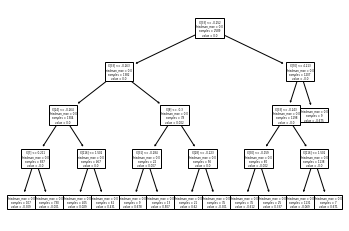

In [246]:
plot_tree(best_model.best_estimator_.named_steps['clf'].estimators_[
        which_tree,
        which_target
    ]);

In [239]:
which_tree = np.random.choice(gb.best_params_['clf__n_estimators'])
which_target = np.random.choice(3)

dot_data = StringIO()  
export_graphviz(
    best_model.best_estimator_.named_steps['clf'].estimators_[
        which_tree,
        which_target
    ],
    out_file=dot_data,  
    filled=True, 
    rounded=True,
    special_characters=True)  
graph = graph_from_dot_data(dot_data.getvalue()) 
print('Tree Number: {}'.format(which_tree))
print('Target: {}'.format(target_names[which_target]))
Image(graph.create_png())

Tree Number: 80
Target: mid-cap


In [152]:
confusion_matrix(y_test, y_pred)

array([[474,   0,   0],
       [  0, 143,   8],
       [  0,  17, 221]])

In [138]:
y_pred = best_model.predict(X_test)
wrong_preds = []
for n, (i, v) in enumerate(y_test.items()):
    if v !=  y_pred[n]:
        print(i, v, y_pred[n])
        wrong_preds.append(i)

2283 1.0 2.0
2044 2.0 1.0
1619 2.0 1.0
391 2.0 1.0
2284 1.0 2.0
1423 2.0 1.0
334 2.0 1.0
148 2.0 1.0
1478 2.0 1.0
1632 1.0 2.0
57 1.0 2.0
2590 2.0 1.0
2043 2.0 1.0
1489 1.0 2.0
2047 1.0 2.0
447 2.0 1.0
1481 2.0 1.0
149 2.0 1.0
2353 1.0 2.0
380 1.0 2.0
1479 2.0 1.0
2045 2.0 1.0
449 2.0 1.0
335 2.0 1.0
273 2.0 1.0


In [143]:
df.loc[wrong_preds, ['year', 'security', 'cap']]

,year,security,cap
2283,2013.0,ICU Medical,1.0
2044,2017.0,"Great Western Bancorp, Inc.",2.0
1619,2014.0,Endo International plc,2.0
391,2018.0,Apollo Commercial Real Estate,2.0
2284,2014.0,ICU Medical,1.0
1423,2017.0,"Dine Brands Global, Inc.",2.0
334,2016.0,Amn Healthcare Services Inc,2.0
148,2016.0,Akorn,2.0
1478,2013.0,Dun & Bradstreet Corp,2.0
1632,2015.0,Energizer Holdings Inc,1.0
